In [7]:
import pickle
import csv
import numpy as np
import os

In [8]:
file_exp_value = "data/pdbbind_refined_set.csv"
data_dir = "data"

In [9]:
# Read the data file and get all the pdb ids
def read_score():
    pdb_ids = []
    scores = {}
    with open(file_exp_value, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None) # Skip the header
        for row in reader:
            pdb_ids.append(row[1])
            scores[row[1]]= float(row[5])

    return pdb_ids, scores

In [102]:
def _reshape(x, new_shape):
    dim_diff = np.subtract(new_shape, x.shape)
    pad_dim = np.round(dim_diff / 2).astype(int)
    x = np.pad(x, [(pad_dim[0], dim_diff[0]-pad_dim[0]),
                   (pad_dim[1], dim_diff[1]-pad_dim[1]),
                   (pad_dim[2], dim_diff[2]-pad_dim[2]),
                   (0, 0)],
               'constant')
    
    return x

In [204]:
def read_data():
    features_file = os.path.join(data_dir, "features_side_1_neigh.pickle")
    
    with open(features_file, "rb") as f:
        features = pickle.load(f)
    
    # Reshape features
    shape_ar = np.array([f.shape for f in features.values()], dtype=np.int)
    new_shape = np.amax(shape_ar, axis=0)
    #new_shape = np.array([24, 24, 24, 8])
    features_array = np.array([_reshape(f, new_shape) for f in features.values()], dtype=np.float32)
    return list(features.keys()), features_array
    #return list(features.keys()), np.array(list(features.values()), dtype=np.float32)

In [205]:
exp_ids, exp_scores = read_score()
pdb_ids, features = read_data()

In [206]:
print(len(exp_ids), len(exp_scores), len(pdb_ids), features.shape)

4154 4154 3882 (3882, 47, 45, 46, 8)


In [207]:
# Valid features (has exp values)
found_mask = [i in exp_ids for i in pdb_ids]
features = features[found_mask]
valid_pdb_ids = [i for i in pdb_ids if i in exp_ids]
exp_values = np.array([exp_scores[k] for k in valid_pdb_ids], dtype=np.float32)

In [208]:
print(features.shape, len(exp_values))

(3650, 47, 45, 46, 8) 3650


In [209]:
np.var(features.reshape((-1, 8)), axis=0)

array([0.01467088, 0.00285977, 0.00857883, 0.01577183, 0.009899  ,
       0.        , 0.0250599 , 0.        ], dtype=float32)

In [210]:
from sklearn.model_selection import train_test_split

In [211]:
train_x, test_x, train_y, test_y = train_test_split(features, exp_values, test_size=0.2, random_state=1)
test_x, valid_x, test_y, valid_y = train_test_split(test_x, test_y, test_size=0.5, random_state=1)
print(train_x.shape, test_x.shape, valid_x.shape)

(2920, 47, 45, 46, 8) (365, 47, 45, 46, 8) (365, 47, 45, 46, 8)


In [212]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from tqdm import *
import glob
import os
import random
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [214]:
def get_model1(summary=False):
    """ Return the Keras model of the network
    """
    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     input_shape=(47, 45, 46, 8),
                     padding='same',
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     bias_initializer='zeros'))
    
    model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 2nd layer group
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     padding='same'))
    
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 3rd layer group
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     padding='same'))
    
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 4th layer group
#     model.add(Conv3D(filters=128,
#                      kernel_size=(3, 3, 3),
#                      activation='relu',
#                      padding='valid'))
    
#     model.add(MaxPooling3D(pool_size=(2, 2, 2),
#                            #strides=(1, 1, 1),
#                            padding='valid'))
    
    #model.add(AveragePooling3D(pool_size=(2, 2, 2), 
    #                           padding='valid'))
                           
    model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(256, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(1, activation='linear'))
    if summary:
        print(model.summary())
    return model

In [215]:
nb_gpus = 8
nb_batch = nb_gpus*32
nb_epochs = 100
l_rate = 0.00001

In [216]:
model = get_model1()
model = multi_gpu_model(model, gpus=nb_gpus)
model.compile(optimizer=optimizers.rmsprop(lr=l_rate),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [217]:
history1 = model.fit(train_x, train_y, 
                    validation_data=(valid_x, valid_y),
                    epochs=nb_epochs,
                    batch_size=nb_batch,
                    verbose=1)

Train on 2920 samples, validate on 365 samples
Epoch 1/100
2920/2920 [==============================] - 54s 19ms/step - loss: 6.8337 - mean_squared_error: 6.8337 - val_loss: 3.3851 - val_mean_squared_error: 3.3851
Epoch 2/100
2920/2920 [==============================] - 26s 9ms/step - loss: 3.3127 - mean_squared_error: 3.3127 - val_loss: 3.4754 - val_mean_squared_error: 3.4754
Epoch 3/100
2920/2920 [==============================] - 23s 8ms/step - loss: 3.2424 - mean_squared_error: 3.2424 - val_loss: 3.1614 - val_mean_squared_error: 3.1614
Epoch 4/100
2920/2920 [==============================] - 21s 7ms/step - loss: 3.2079 - mean_squared_error: 3.2079 - val_loss: 3.1150 - val_mean_squared_error: 3.1150
Epoch 5/100
2920/2920 [==============================] - 21s 7ms/step - loss: 3.1682 - mean_squared_error: 3.1682 - val_loss: 3.1883 - val_mean_squared_error: 3.1883
Epoch 6/100
2920/2920 [==============================] - 20s 7ms/step - loss: 2.9973 - mean_squared_error: 2.9973 - val_lo

Epoch 50/100
2920/2920 [==============================] - 20s 7ms/step - loss: 2.1740 - mean_squared_error: 2.1740 - val_loss: 2.6889 - val_mean_squared_error: 2.6889
Epoch 51/100
2920/2920 [==============================] - 20s 7ms/step - loss: 2.1127 - mean_squared_error: 2.1127 - val_loss: 3.1597 - val_mean_squared_error: 3.1597
Epoch 52/100
2920/2920 [==============================] - 20s 7ms/step - loss: 2.1303 - mean_squared_error: 2.1303 - val_loss: 2.9591 - val_mean_squared_error: 2.9591
Epoch 53/100
2920/2920 [==============================] - 19s 7ms/step - loss: 2.1910 - mean_squared_error: 2.1910 - val_loss: 3.6251 - val_mean_squared_error: 3.6251
Epoch 54/100
2920/2920 [==============================] - 20s 7ms/step - loss: 2.2463 - mean_squared_error: 2.2463 - val_loss: 2.7256 - val_mean_squared_error: 2.7256
Epoch 55/100
2920/2920 [==============================] - 21s 7ms/step - loss: 1.9846 - mean_squared_error: 1.9846 - val_loss: 2.7087 - val_mean_squared_error: 2.708

2920/2920 [==============================] - 20s 7ms/step - loss: 1.4385 - mean_squared_error: 1.4385 - val_loss: 2.7756 - val_mean_squared_error: 2.7756
Epoch 100/100
2920/2920 [==============================] - 21s 7ms/step - loss: 1.5920 - mean_squared_error: 1.5920 - val_loss: 2.5969 - val_mean_squared_error: 2.5969


In [218]:
history1.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

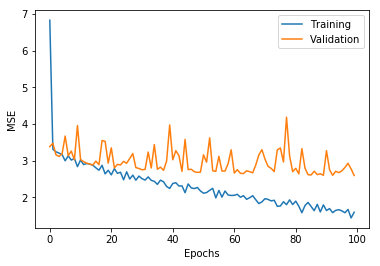

In [219]:
plt.figure()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(["Training", "Validation"])
plt.show()

In [220]:
train_r2 = r2_score(y_pred=model.predict(train_x), y_true=train_y)
test_r2 = r2_score(y_pred=model.predict(test_x), y_true=test_y)
valid_r2 = r2_score(y_pred=model.predict(valid_x), y_true=valid_y)
print("Train R2: %0.3f , Test R2: %0.3f, Valid R2: %0.3f" % (train_r2, test_r2, valid_r2))

Train R2: 0.669 , Test R2: 0.253, Valid R2: 0.355


## Result

#### With voxel size = 1 
Train R2: 0.511 , Test R2: 0.221, Valid R2: 0.306

#### With voxel size = 2
Train R2: 0.489 , Test R2: 0.221, Valid R2: 0.296

#### With voxel size = 3
Train R2: 0.474 , Test R2: 0.235, Valid R2: 0.286

#### With voxel size = 1 (8 neighbors)
Train R2: 0.669 , Test R2: 0.253, Valid R2: 0.355

#### With voxel size = 2 (8 neighbors)
Train R2: 0.487 , Test R2: 0.238, Valid R2: 0.329

#### With voxel size = 3 (8 neighbors)
Train R2: 0.326 , Test R2: 0.133, Valid R2: 0.193